# Final Project - Refugee Data Visualization

Ben Heinze, Elizabeth Pauley

CSCI-491 - Data Visualization

3 May 2024

### Dataset
* [UNHCR Refugee Dataset link](https://github.com/rfordatascience/tidytuesday/tree/master/data/2023/2023-08-22)

### Helpful Information
- [What is a Host Community Member?](https://www.unhcr.org/us/publications/unhcr-ngo-toolkit-practical-cooperation-resettlement-community-outreach-outreach-0)
- [What is Statelessness?](https://www.unhcr.org/ibelong/about-statelessness/)

### Dataset Description

| Variable          | Class     | Description                                                     |
|-------------------|-----------|-----------------------------------------------------------------|
| year              | int64     | The year.                                                       |
| coo_name          | character | Country of origin name.                                         |
| coo               | character | Country of origin UNHCR code.                                   |
| coo_iso           | character | Country of origin ISO code.                                     |
| coa_name          | character | Country of asylum name.                                         |
| coa               | character | Country of asylum UNHCR code.                                   |
| coa_iso           | character | Country of asylum ISO code.                                     |
| refugees          | int64     | The number of refugees from COO in COA.                         |
| asylum_seekers    | int64     | The number of asylum-seekers from COO in COA.                   |
| returned_refugees | int64     | The number of refugees returned to COO from COA                 |
| idps              | int64     | The number of internally displaced persons.                     |
| returned_idps     | int64     | The number of returned internally displaced persons.            |
| stateless         | int64     | The number of stateless persons.                                |
| ooc               | int64     | The number of others of concern to UNHCR.                       |
| oip               | float     | The number of other people in need of international protection. |
| hst               | float     | The number of host community members.                           |

### Questions we Hope to Answer
1. Is there correlation between the country of origin of refugees and the countries where they seek aslyum?
2. Which countries have the highest proportion of returned-refugees to refugees?
3. PCA (TBD)
4. Clustering (TBD)
5. Statelessness (TBD)

## Setup

---

In [1]:
import numpy as np
import pandas as dp
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

data = dp.read_csv("data/population.csv")

#removes repetitive columns (country or origin/asylum initials)
data = data.drop(columns = ['coo','coo_iso','coa','coa_iso'])

# Numerical data
num_data = data.drop(columns = ['coo_name','coa_name'])
data

,year,coo_name,coa_name,refugees,asylum_seekers,returned_refugees,idps,returned_idps,stateless,ooc,oip,hst
0,2010,Afghanistan,Afghanistan,0,0,0,351907,3366,0,838250,NaN,NaN
1,2010,Iran (Islamic Rep. of),Afghanistan,30,21,0,0,0,0,0,NaN,NaN
2,2010,Iraq,Afghanistan,6,0,0,0,0,0,0,NaN,NaN
3,2010,Pakistan,Afghanistan,6398,9,0,0,0,0,0,NaN,NaN
4,2010,Egypt,Albania,5,0,0,0,0,0,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
64804,2022,Venezuela (Bolivarian Republic of),Aruba,0,0,0,0,0,0,0,17000.0,0.0
64805,2022,Aruba,Aruba,0,0,0,0,0,0,0,NaN,1700.0
64806,2022,Venezuela (Bolivarian Republic of),Curacao,0,0,0,0,0,0,0,14000.0,0.0
64807,2022,Curacao,Curacao,0,0,0,0,0,0,0,NaN,1700.0


## Preprocessing

---

Out of the entire dataset, only two columns has missing values: __oip__ and __hst__. Since they only have 100 and 5964 datapoints respectively out of 64809, we will not use a filling technique as the majority of the data is missing. __hst__ was only captured in 2022 and a fraction of 2021. __Learn more about oip's nulls; Choose to keep or drop these columns.__ 

## Question 1

---

Question: Is there correlation between the country of origin of refugees and the countries where they seek asylum? Analyze this for both refugees and asylum_seekers, then compare and contrast.

We have a dictionary that stores the country of origin, and returns a list of countries where asylum-seekers from the country of origin migrate to.

Example: 30 people seek asylum from Iran. 20 of them go to Canada, 8 go to United States, and 2 go to Saudi Arabia. \
Output: `Iran: [ {Canada:20}, {United States: 10}, {Saudi Arabia: 2} ]`

#### Asylum Seeker Results

In [2]:
def generate_asylum_dictionary(data):
    d_coo = {}  #Dictionary of country of origin. { CountryOfOrigin: [listOfCountryAsylums] }
    for index, series in data.iterrows():
        coo = series['coo_name']  # country of origin string
        coa = series['coa_name']  # country of asylum string
        asylum_seekers = series['asylum_seekers']  # number of asylum seekers from COO to COA
        d_coa = {}  #Dictionary for country of asylum  {CountryOfAsylum: numberOfAsylumSeekers }

        # counts the number of asylum_seekers from COO to COA
        if asylum_seekers > 0:
            if coa not in d_coa:  #If countryOfAsylum isnt in the dict, add it with current value.
                d_coa[coa] = asylum_seekers
            else:  # If it's in the dict, increment dict
                d_coa[coa] += asylum_seekers

            # Create a list of Dictionaries if the country of origin doesn't exist in the COO dictionary yet
            if coo not in d_coo:
                d_coo[coo] = d_coa
            else:  # add the Country of asylum to the list if the COO does exist in the coo_dictionary
                d_coo[coo].update(d_coa)
    return d_coo

#### Refugee Results

In [3]:
def generate_refugee_dictionary(data):
    d_coo = {}  #Dictionary of country of origin. { CountryOfOrigin: [listOfCountryAsylums] }
    for index, series in data.iterrows():
        coo = series['coo_name']  # country of origin string
        coa = series['coa_name']  # country of asylum string
        refugees = series['refugees']  # number of refugees from COO to COA
        d_coa = {}  #Dictionary for country of asylum  {CountryOfAsylum: numberOfRefugees }

        # counts the number of refugees from COO to COA
        if refugees > 0:
            if coa not in d_coa:  #If countryOfAsylum isnt in the dict, add it with current value.
                d_coa[coa] = refugees
            else:  # If it's in the dict, increment dict
                d_coa[coa] += refugees

            # Create a list of Dictionaries if the country of origin doesn't exist in the COO dictionary yet
            if coo not in d_coo:
                d_coo[coo] = d_coa
            else:  # add the Country of asylum to the list if the COO does exist in the coo_dictionary
                d_coo[coo].update(d_coa)
    return d_coo

#### Plotting Asylum Seekers from Specified Country to World Map

In [16]:
'''
    parameters:
        country - Chooses the Country of Origin to Plot
        dictionaryData - Dictionary of country:data
        isAsylum - is the data asylum_seekers(True) or refugees(false) (only changes title) 
'''
def plot_heat_map(country, dictionaryData, isAsylum):
    # Generates Data from Country
    data = dictionaryData[country]

    # Load world shapefile
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    world = world[(world.name != 'Antarctica')]  # Removes Antartica
    # Map the data to the image
    world['data'] = world['name'].map(data)
    
    # Plot
    fig, ax = plt.subplots(1, 1, figsize=(13, 10))
    world.boundary.plot(ax=ax, linewidth=0.8)
  
    if isAsylum:
        world.plot(column='data', cmap='plasma', ax=ax, legend=True, 
                   legend_kwds={'label': "Number of Asylum Seekers", 'orientation': "horizontal"})
        ax.set_title(f"World Heat Map of Where Asylum Seekers Find Refuge from {country} ({sum(data.values())} total)",fontsize=14)
        
        # determine 95th percentile of data in order to label top 5% country names
        asylumNonZero = num_data[num_data['asylum_seekers'] > 0]
        asylumThreshold = asylumNonZero['asylum_seekers'].quantile(0.95)

        for idx, row in world.iterrows():
            if row['data'] > asylumThreshold:
                ax.text(row.geometry.centroid.x, row.geometry.centroid.y, row['name'], fontsize=10)
    else:
        world.plot(column='data', cmap='plasma', ax=ax, legend=True, 
                   legend_kwds={'label': "Number of Refugees", 'orientation': "horizontal"})
        ax.set_title(f"World Heat Map of Where Refugees Find Refuge from {country} ({sum(data.values())} total)",fontsize=14)
        
        # determine 95th percentile of data in order to label top 5% country names
        refugeeNonZero = num_data[num_data['refugees'] > 0]
        refugeeThreshold = refugeeNonZero['refugees'].quantile(0.95)
        print(refugeeThreshold)

        for idx, row in world.iterrows():
            if row['data'] > refugeeThreshold:
                ax.text(row.geometry.centroid.x, row.geometry.centroid.y, row['name'], fontsize=10)
    plt.show()

### Plot Refugees and Asylum Maps

5198.799999999952


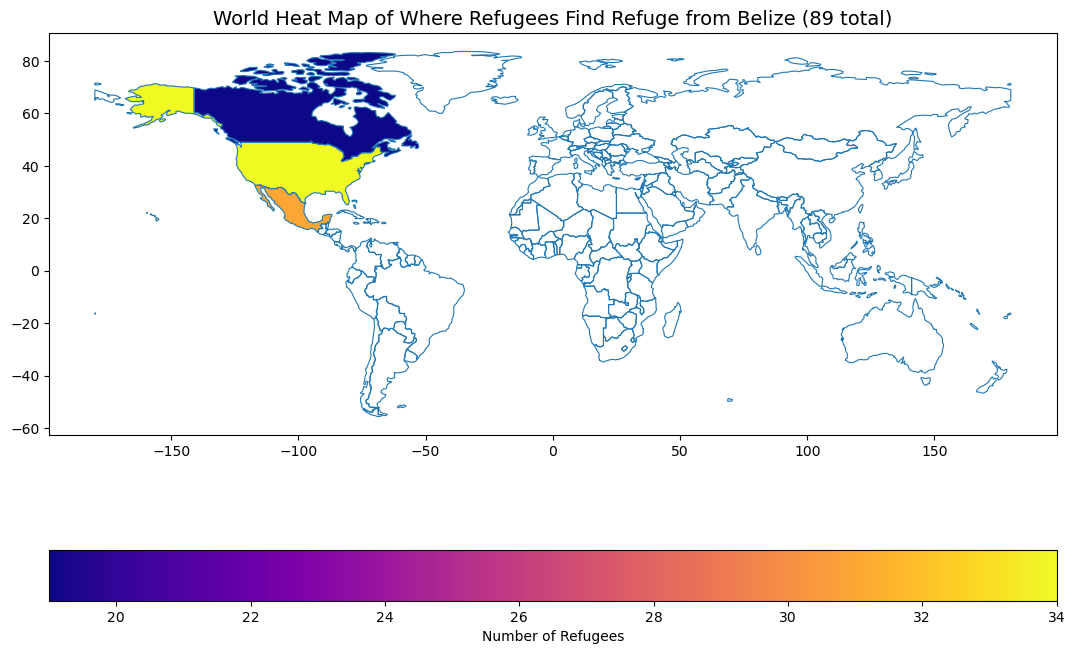

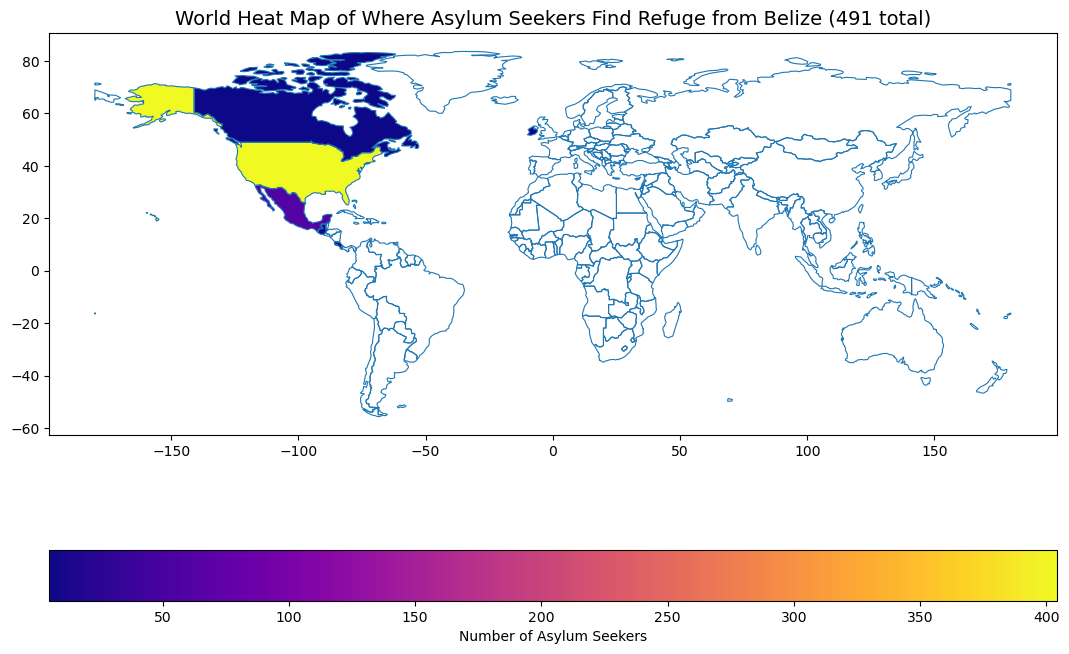

In [17]:
country = 'Belize' # Select Country Of Origin 

# Plot the heat map of whichever country of origin, 
plot_heat_map(country, generate_refugee_dictionary(data), False)
plot_heat_map(country, generate_asylum_dictionary(data), True)


## Question 2

---


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def calculate_returned_refugees_ratio(data):
    # Create dictionaries to store total refugees and total returned refugees for each country
    total_refugees = {}
    total_returned_refugees = {}

    # Iterate over the rows of the DataFrame
    for index, row in data.iterrows():
        # Extract relevant information from the row
        coo_name = row['coo_name']
        refugees = row['refugees']
        returned_refugees = row['returned_refugees']

        # Update total refugees for the country of origin
        if coo_name in total_refugees:
            total_refugees[coo_name] += refugees
        else:
            total_refugees[coo_name] = refugees

        # Update total returned refugees for the country of origin
        if coo_name in total_returned_refugees:
            total_returned_refugees[coo_name] += returned_refugees
        else:
            total_returned_refugees[coo_name] = returned_refugees

    # Calculate the ratio of returned refugees to total refugees for each country
    returned_ratio = {}
    for coo_name in total_refugees:
        if total_refugees[coo_name] != 0:
            returned_ratio[coo_name] = total_returned_refugees[coo_name] / total_refugees[coo_name]
        else:
            returned_ratio[coo_name] = 0

    # Sort countries based on the calculated returned refugees ratio
    sorted_countries = sorted(returned_ratio.keys(), key=lambda x: returned_ratio[x], reverse=True)[:20]

    # Plot the bar chart with a logarithmic scale on the y-axis
    plt.figure(figsize=(10, 6))
    bars = plt.bar(sorted_countries, [returned_ratio[coo_name] for coo_name in sorted_countries])
    plt.xlabel('Country of Origin')
    plt.ylabel('Returned Refugees Ratio')
    plt.title('Ratio of Returned Refugees to Total Refugees by Country of Origin (Top 20)')
    plt.xticks(rotation=75)
    plt.yscale('log')  # Apply logarithmic scale to y-axis

    # Add text labels on top of each bar
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, '{:.3f}'.format(height), ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

# Assuming 'data' is your pandas DataFrame
# Call the function
calculate_returned_refugees_ratio(data)

## Question 3

---

Question: Which countries are historically the most popular as countries of asylum for stateless individuals?

Generate a dictionary that stores the name of each country of asylum and the associated overall number of stateless individuals that have sought asylum for that country.

Utilize geopandas to create a choropleth that displays values by color for each country.

#### Stateless Individual Results

In [ ]:
def generate_stateless_dictionary(data, year):
    statelessData = data # use all data initially

    if (year >= 2010 and year <= 2022): # if a valid year is provided, create subset of data for specific year
        statelessData = data[data['year'] == int(year)]  # dataframe of specific year
        
    d_coa = {}  # dictionary of country of origin. { CountryOfAsylum:numStatelessIndividuals }
    for index, series in statelessData.iterrows():
        coa = series['coa_name']  # country of asylum string
        stateless = series['stateless']  # number of stateless individuals

        # counts the number of stateless individuals for each COA
        if stateless > 0:
            if coa not in d_coa:  #If countryOfAsylum is not in the dict, add it with current value.
                d_coa[coa] = stateless
            else:  # If it's in the dict, increment dict
                d_coa[coa] += stateless
    return d_coa

In [ ]:
statelessYear = 0 # year to graph
statelessByCOA = generate_stateless_dictionary(data, statelessYear)

# heat map that visualizes population of stateless refugees in each country

# Load world shapefile
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world[(world.name != 'Antarctica')]  # Removes Antartica
# Map the data to the image
world['data'] = world['name'].map(statelessByCOA)

# Plot
fig, ax = plt.subplots(1, 1, figsize=(13, 10))
world.boundary.plot(ax=ax, linewidth=0.8)

world.plot(column='data', cmap='plasma', ax=ax, legend=True, 
                   legend_kwds={'label': "Number of Stateless Individuals",
                                'orientation': "horizontal",
                              'format':"%.0f"})

# determine 95th percentile of data in order to label top 5% country names
statelessNonZero = data[data['stateless'] > 0]
statelessThreshold = statelessNonZero['stateless'].quantile(0.95)

for idx, row in world.iterrows():
    if row['data'] > statelessThreshold:
        ax.text(row.geometry.centroid.x, row.geometry.centroid.y, row['name'], fontsize=10)

if (statelessYear >= 2010 and statelessYear <= 2022):
    ax.set_title(f"World Heat Map of Where Stateless Individuals Resided in {statelessYear}",fontsize=14)
else:
    ax.set_title(f"World Heat Map of Where Stateless Individuals Have Historically Resided",fontsize=14)
    
plt.show()

Question 4

---

In [ ]:
import pandas as pd
# ------------ CALCULATE REFUGEE AND ASYLUM-SEEKER DATA ------------ #
# determine countries with the top 10 highest numbers of refugees from 2010-2022
totalRefsByCtry = data.groupby(['coo_name'])['refugees'].sum().reset_index()
topTenRefCountries = totalRefsByCtry.nlargest(10, ['refugees'])['coo_name']

# calculate number of refugees per year for the top 10 countries
subsetData = data[data['coo_name'].isin(topTenRefCountries)]
refugeePlotValues = subsetData.groupby(['year', 'coo_name'])['refugees'].sum().reset_index()
#refugeePlotValues

# determine countries with the top 10 highest numbers of asylum-seekers from 2010-2022
totalSkersByCtry = data.groupby(['coo_name'])['asylum_seekers'].sum().reset_index()
topTenSkrCountries = totalSkersByCtry.nlargest(10, ['asylum_seekers'])['coo_name']

# calculate number of asylum-seekers per year for the top 10 countries
subsetData = data[data['coo_name'].isin(topTenSkrCountries)]
seekerPlotValues = subsetData.groupby(['year', 'coo_name'])['asylum_seekers'].sum().reset_index()
#seekerPlotValues

# get list of countries to be used for graph colors
uniqueCountries = (pd.concat([refugeePlotValues['coo_name'], seekerPlotValues['coo_name']])).unique()

In [ ]:
# plot top 10 countries producing refugees overall
fig, axs = plt.subplots(2, 1, figsize=(10, 12))

# --------------------------- PLOT DATA --------------------------- #
# Assign colors to countries
colors = plt.cm.tab20(np.linspace(0, 1, len(uniqueCountries)))
color_dict = {country: color for country, color in zip(uniqueCountries, colors)}

# REFUGEE DATA
for country, group in refugeePlotValues.groupby('coo_name'):
    axs[0].plot(group['year'], group['refugees'], label=country, color=color_dict[country])

axs[0].ticklabel_format(style='plain')
axs[0].set_title('Number of Refugees Per Year from the Top 10 Refugee-Producing Countries')
axs[0].set_xlabel('Year')
axs[0].set_ylabel('Total Refugees')
axs[0].legend(loc='best')

# ASYLUM-SEEKER DATA
for country, group in seekerPlotValues.groupby('coo_name'):
    axs[1].plot(group['year'], group['asylum_seekers'], label=country, color=color_dict[country])

axs[1].ticklabel_format(style='plain')
axs[1].set_title('Number of Asylum-Seekers Per Year from the Top 10 Asylum-Seeker-Producing Countries')
axs[1].set_xlabel('Year')
axs[1].set_ylabel('Total Asylum-Seekers')
axs[1].legend(loc='best')

plt.show()

In [ ]:
# visual to investigate spike in asylum-seekers with unknown coo as seen in previous graph
unknownCOOData = data[(data['coo_name'] == 'Unknown') & (data['year'] == 2015) & (data['asylum_seekers'] != 0)].sort_values(by='asylum_seekers', ascending=False)
topAsylumSeekrsUnknown = unknownCOOData.nlargest(10, ['asylum_seekers'])

barColors = plt.cm.tab10(np.linspace(0, 1, 10))

#topAsylumSeekrsUnknown
ax = topAsylumSeekrsUnknown.plot(x='coa_name', y='asylum_seekers', kind='barh', legend=False, color = barColors)
plt.title('Countries with the Top 10 Number of Asylum-Seekers with an Unknown Country of Origin, Ascending')
plt.xlabel('Number of Asylum-Seekers (Logarithmically-Scaled)')
plt.ylabel('Country')
plt.xscale("log")
plt.show()

# need to look into below link:
# https://africacheck.org/fact-checks/reports/south-africa-home-more-million-asylum-seekers-numbers-dont-add#:~:text=According%20to%20the%20report%2C%20by%20the%20end%20of,Africa%20had%20listed%20only%20463%2C900%20pending%20asylum%20claims.